Modelo YOLOv8 cargado desde ./runs/segment/train22/weights/best.pt en cuda

0: 704x1024 5 persons, 2 roads, 1 building, 24.0ms
Speed: 7.0ms preprocess, 24.0ms inference, 3.0ms postprocess per image at shape (1, 3, 704, 1024)


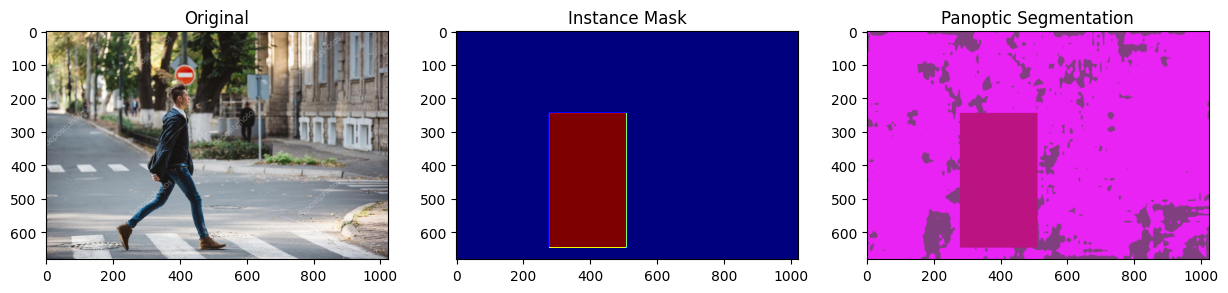

: 

In [ ]:
import numpy as np
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn

# Diccionario de colores por clase semántica
class_colors = {
    0: [0, 0, 0],         # background
    1: [128, 64, 128],    # road
    2: [244, 35, 232],    # sidewalk
    3: [70, 70, 70],      # building
    4: [220, 20, 60],     # person/rider (común para instancias)
}

def calculate_bbox_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def merge_yolo_deeplab(yolo_results, deeplab_prediction, confidence_threshold=0.5):
    instance_mask = np.zeros_like(deeplab_prediction)
    instance_id = 1
    instance_info = {}

    for detection in yolo_results:
        if detection[4] < confidence_threshold:
            continue

        x1, y1, x2, y2 = map(int, detection[:4])
        class_id = int(detection[5])

        if class_id in [0, 1]:  # person o rider
            instance_mask[y1:y2, x1:x2] = instance_id
            instance_info[instance_id] = {
                'class_id': class_id,
                'bbox': [x1, y1, x2, y2],
                'confidence': detection[4]
            }
            instance_id += 1

    return instance_mask, instance_info

def create_panoptic_visualization(image, instance_mask, semantic_mask, instance_info):
    instance_colors = np.random.randint(0, 255, (len(instance_info) + 1, 3))
    instance_colors[0] = [0, 0, 0]

    panoptic_vis = np.zeros((*image.shape[:2], 3), dtype=np.uint8)

    for class_id, color in class_colors.items():
        panoptic_vis[semantic_mask == class_id] = color

    for instance_id, info in instance_info.items():
        mask = instance_mask == instance_id
        panoptic_vis[mask] = instance_colors[instance_id]

    return panoptic_vis

import torchvision.transforms as T

def process_frame(image, yolo_model, deeplab_model, device='cuda'):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # YOLO
    results = yolo_model(image_rgb)[0]
    yolo_results = results.boxes.xyxy.cpu().numpy()
    confs = results.boxes.conf.cpu().numpy()
    class_ids = results.boxes.cls.cpu().numpy()
    yolo_detections = np.hstack([yolo_results, confs[:, None], class_ids[:, None]])

    # DeepLab
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((512, 1024)),  # o la resolución con la que entrenaste DeepLab
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        output = deeplab_model(input_tensor)['out']
    deeplab_prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    # Opcionalmente resize para que coincida con la imagen original
    deeplab_prediction = cv2.resize(deeplab_prediction, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    instance_mask, instance_info = merge_yolo_deeplab(
        yolo_detections,
        deeplab_prediction
    )

    panoptic_vis = create_panoptic_visualization(
        image,
        instance_mask,
        deeplab_prediction,
        instance_info
    )

    return panoptic_vis, instance_mask, instance_info


class InstanceTracker:
    def __init__(self):
        self.previous_instances = {}
        self.next_instance_id = 1

    def update_instances(self, current_instances, iou_threshold=0.5):
        new_instances = {}

        for curr_id, curr_info in current_instances.items():
            best_iou = 0
            best_prev_id = None

            for prev_id, prev_info in self.previous_instances.items():
                iou = calculate_bbox_iou(
                    curr_info['bbox'],
                    prev_info['bbox']
                )
                if iou > iou_threshold and iou > best_iou:
                    best_iou = iou
                    best_prev_id = prev_id

            if best_prev_id is not None:
                new_instances[best_prev_id] = curr_info
            else:
                new_instances[self.next_instance_id] = curr_info
                self.next_instance_id += 1

        self.previous_instances = new_instances
        return new_instances

def process_video(video_path, yolo_model, deeplab_model, device='cuda'):
    cap = cv2.VideoCapture(video_path)
    tracker = InstanceTracker()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        panoptic_vis, instance_mask, instance_info = process_frame(
            frame,
            yolo_model,
            deeplab_model,
            device
        )

        instance_info = tracker.update_instances(instance_info)

        cv2.imshow('Panoptic Segmentation', panoptic_vis)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

def load_deeplab_model(model_path, device='cuda'):
    model = deeplabv3_resnet50(pretrained=False)
    model.classifier[-1] = nn.Conv2d(256, 5, kernel_size=(1, 1))
    
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['model_state']
    keys_to_remove = [k for k in state_dict if k.startswith('aux_classifier')]
    for k in keys_to_remove:
        del state_dict[k]

    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model

def load_yolo_model(model_path=None, task='detect', device='cuda'):
    from ultralytics import YOLO

    if model_path is None:
        model_path = 'yolov8n.pt' if task == 'detect' else './runs/segment/train22/weights/best.pt'

    model = YOLO(model_path)
    model.to(device)
    model.eval()
    print(f"Modelo YOLOv8 cargado desde {model_path} en {device}")
    return model

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    yolo_model = load_yolo_model(None, 'segment', device)
    deeplab_model = load_deeplab_model(
        r'C:\Users\aaron\Documents\GitHub\DeepLabV3Plus-Pytorch\checkpoints\best_deeplabv3plus_resnet50_voc_os16.pth',
        device
    )

    image_path = "./depositphotos_58088201-stock-photo-young-man-cross-the-street-2946890742.jpg"
    image = cv2.imread(image_path)

    panoptic_vis, instance_mask, instance_info = process_frame(
        image,
        yolo_model,
        deeplab_model,
        device
    )

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original')

    plt.subplot(132)
    plt.imshow(instance_mask, cmap='jet')
    plt.title('Instance Mask')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(panoptic_vis, cv2.COLOR_BGR2RGB))
    plt.title('Panoptic Segmentation')
    plt.show()

    # Para procesar video, descomenta:
    # process_video("example.mp4", yolo_model, deeplab_model, device)

if __name__ == '__main__':
    main()
